<a href="https://www.kaggle.com/sinoro12/predicting-medical-cost-80-r-2-for-all-models?scriptVersionId=89119214" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

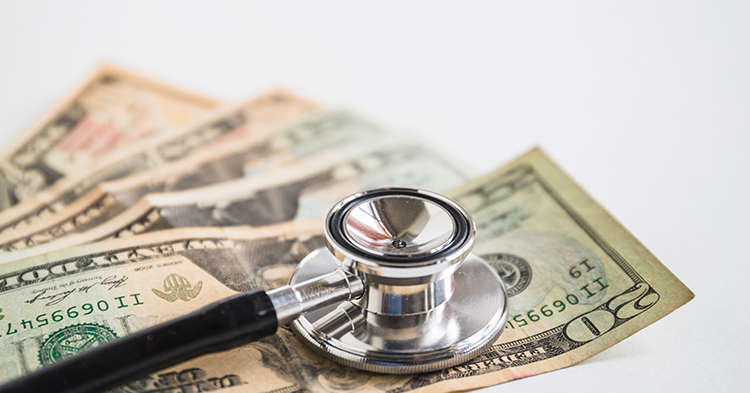

# I. Importing libraries and data

In [1]:
#imports for data analysis and wrangling
import pandas as pd
import numpy as np

#visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#Linear Regression
from scipy.stats import linregress

#Train_test_split
from sklearn.model_selection import train_test_split

#cross_val_score
from sklearn.model_selection import cross_val_score

#scaling
from sklearn.preprocessing import StandardScaler

#gridsearch
from sklearn.model_selection import GridSearchCV

#models
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor

#score
from sklearn.metrics import r2_score

#Importing data
insurance = pd.read_csv("../input/insurance/insurance.csv")


# II. Analyze by describing the data

In [2]:
#Examining the first 5 observations
display(insurance.head())
#Examining the last 5 observations
display(insurance.tail())
#Summary statistics of features
display(insurance.describe())

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


,age,sex,bmi,children,smoker,region,charges
1333,50,male,30.97,3,no,northwest,10600.5483
1334,18,female,31.92,0,no,northeast,2205.9808
1335,18,female,36.85,0,no,southeast,1629.8335
1336,21,female,25.80,0,no,southwest,2007.9450
1337,61,female,29.07,0,yes,northwest,29141.3603


,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [3]:
# Getting all the features
print("The column names of the dataframe are the following in this list:", insurance.columns.values)
print("------------------------------------")

#Getting the number of rows and columns in the table
print("The shape of the dataframe is", insurance.shape)
print("------------------------------------")

#Checking for null values
print(insurance.isnull().sum())
print("------------------------------------")

#Examining the data types of various features
print(insurance.info())
print("------------------------------------")

#Checking the unique values of categorical variables
print("The unique values of categorical variables are")
print(insurance['sex'].value_counts())
print(insurance['children'].value_counts())
print(insurance['region'].value_counts())
print(insurance['smoker'].value_counts())

The column names of the dataframe are the following in this list: ['age' 'sex' 'bmi' 'children' 'smoker' 'region' 'charges']
------------------------------------
The shape of the dataframe is (1338, 7)
------------------------------------
age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64
------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB
None
------------------------------------
The unique values of categorical variables are
male

# III. Preparing the data

**A. Classifying BMI to Categories**
I just did this because I like categrical variables. I got this code from this notebook. You should check it out!
https://www.kaggle.com/janiobachmann/patient-charges-clustering-and-regression

In [4]:
insurance['weight_condition'] = np.nan
df = [insurance]

for col in df:
    col.loc[col.bmi < 18.5, "weight_condition"] = "Underweight"
    col.loc[(col.bmi >= 18.5) & (col.bmi < 24.986), "weight_condition"] = "Normal"
    col.loc[(col.bmi >= 25) & (col.bmi < 29.926), "weight_condition"] = "Overweight"
    col.loc[col.bmi >= 30, "weight_condition"] = "Obese"
display(insurance.head())


,age,sex,bmi,children,smoker,region,charges,weight_condition
0,19,female,27.900,0,yes,southwest,16884.92400,Overweight
1,18,male,33.770,1,no,southeast,1725.55230,Obese
2,28,male,33.000,3,no,southeast,4449.46200,Obese
3,33,male,22.705,0,no,northwest,21984.47061,Normal
4,32,male,28.880,0,no,northwest,3866.85520,Overweight


**B. Changing categorical variables to category data types**

This can be helpful in speeding up our code. Here, we will change the datatype of categorical variables in the insurance dataframe that are currently object datatypes to categorical datatypes.

In [5]:
#List of categorical variables
categorical = ["sex","children","smoker","region", "weight_condition"]

#Old information of the datatypes in insurance dataframe
print(insurance[categorical].dtypes)

#Converting to categorical datatypes
insurance[categorical] = insurance[categorical].apply(lambda x: x.astype("category"), axis = 0)

#New information of the datatypes in the insurance dataframe
print(insurance[categorical].dtypes)

sex                 object
children             int64
smoker              object
region              object
weight_condition    object
dtype: object
sex                 category
children            category
smoker              category
region              category
weight_condition    category
dtype: object


**C. Creating functions to be used for EDA**

I created the **first two** functions based on the visualizations on this notebook. Please also visit this one. https://www.kaggle.com/namanmanchanda/heart-attack-eda-prediction-90-accuracy

**1. Function for setting up the plotting space, creating a title in the upper left, and creates at most 8 axes**

In [6]:
def setup(title,axnum):
    """ Creates a plotting space for at most 8 subplots including a title on the upper left
    Args:
        title: The title of your plotting space
        axnum: The number of axes in your plotting space"""
    
    #Setting up the plotting space
    fig = plt.figure(figsize=(18,15))
    gs = fig.add_gridspec(3,3)
    gs.update(wspace=0.5, hspace=0.25)
    ax0 = fig.add_subplot(gs[0,0])

    # Title of the plot 
    ax0.spines["bottom"].set_visible(False)
    ax0.spines["left"].set_visible(False)
    ax0.spines["top"].set_visible(False)
    ax0.spines["right"].set_visible(False)
    ax0.tick_params(left=False, bottom=False)
    ax0.set_xticklabels([])
    ax0.set_yticklabels([])
    ax0.text(0.5,0.5,
          title,
         horizontalalignment='center',
         verticalalignment='center',
         fontsize=20, fontweight='bold',
         fontfamily='monospace',
         color="#ffffff")
    ax0.set_facecolor("#000000")
    # overall background color
    fig.patch.set_facecolor("#000000") 
    
    if axnum is 1:
        global ax1
        ax1 = fig.add_subplot(gs[0,1])
    if axnum is 2:
        global ax2
        ax1 = fig.add_subplot(gs[0,1])
        ax2 = fig.add_subplot(gs[0,2])
    if axnum is 3:
        global ax3
        ax1 = fig.add_subplot(gs[0,1])
        ax2 = fig.add_subplot(gs[0,2])
        ax3 = fig.add_subplot(gs[1,0])
    if axnum is 4:
        global ax4
        ax1 = fig.add_subplot(gs[0,1])
        ax2 = fig.add_subplot(gs[0,2])
        ax3 = fig.add_subplot(gs[1,0])
        ax4 = fig.add_subplot(gs[1,1])
    if axnum is 5:
        global ax5
        ax1 = fig.add_subplot(gs[0,1])
        ax2 = fig.add_subplot(gs[0,2])
        ax3 = fig.add_subplot(gs[1,0])
        ax4 = fig.add_subplot(gs[1,1])
        ax5 = fig.add_subplot(gs[1,2]) 
    if axnum is 6:
        global ax6
        ax1 = fig.add_subplot(gs[0,1])
        ax2 = fig.add_subplot(gs[0,2])
        ax3 = fig.add_subplot(gs[1,0])
        ax4 = fig.add_subplot(gs[1,1])
        ax5 = fig.add_subplot(gs[1,2])
        ax6 = fig.add_subplot(gs[2,0])
    if axnum is 7:
        global ax7
        ax1 = fig.add_subplot(gs[0,1])
        ax2 = fig.add_subplot(gs[0,2])
        ax3 = fig.add_subplot(gs[1,0])
        ax4 = fig.add_subplot(gs[1,1])
        ax5 = fig.add_subplot(gs[1,2])
        ax6 = fig.add_subplot(gs[2,0])
        ax7 = fig.add_subplot(gs[2,1])
    if axnum is 8:
        global ax8
        ax1 = fig.add_subplot(gs[0,1])
        ax2 = fig.add_subplot(gs[0,2])
        ax3 = fig.add_subplot(gs[1,0])
        ax4 = fig.add_subplot(gs[1,1])
        ax5 = fig.add_subplot(gs[1,2])
        ax6 = fig.add_subplot(gs[2,0])
        ax7 = fig.add_subplot(gs[2,1])
        ax8 = fig.add_subplot(gs[2,2])
        


**2. Function for creating seaborn subplots in the plotting space**

In [7]:
def plot(ax,sns,var1,var2,category,x,y,title):
    """ Creates a seaborn subplot based on the axes it was assigned to.
    Args:
        ax: The ax where the data will be plotted
        sns: Type of seaborn plot to be used
        var1: X variable to be considered in the seaborn plot
        var2: Y variable to be considered in the seaborn plot
        category: Hue of the seaborn plot
        x: x-coordinate of the placement of the title in the plotting space
        y: y-coordinate of the placement of the title in the plotting space
        title: title of the subplot"""
    ax.text(x,y,title, fontsize=14, fontweight='bold', fontfamily='monospace', color="#ffffff")
    ax.grid(color='#ffffff', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
    sns(ax=ax,x = var1, y = var2, data=insurance, hue = category,
        palette=["#aec6cf", "#ff6961", "#74d89c", "#ffb347"])

    #Annotations of the plot
    ax.set_xlabel(var1, color = 'white')
    ax.set_ylabel(var2, color = 'white')
    ax.spines[["top","right","left"]].set_visible(False) # removes the square margins in the graph
    ax.set_facecolor("#000000") #background color of the graph
    
    #Changing the color of x ticks and y ticks
    ax.tick_params(axis='x', colors='white')
    ax.tick_params(axis='y', colors='white')
    


**3. Function for ecdf**
Empirical cumulative distribution function short for ECDF essentially allows you to plot a feature of your data in order from least to greatest and see the whole feature as if is distributed across the data set. And then, it is used to determine the percentage of data points that are less than the  certain x-value for example, 5.

**If you did not understand what I am saying above:**
https://towardsdatascience.com/what-why-and-how-to-read-empirical-cdf-123e2b922480

**Code I used:**
https://campus.datacamp.com/courses/statistical-thinking-in-python-part-1/graphical-exploratory-data-analysis?ex=12

In [8]:
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    # Number of data points: n
    n = len(data)

    # x-data for the ECDF: x
    x = np.sort(data)

    # y-data for the ECDF: y
    y = np.arange(1, n+1) / n

    return x, y


**4, Function for creating ecdf subplots in the plotting space**

In [9]:
def cdf(ax,data,column,group1,group2, group3 = None, group4 = None, group5 = None, group6 = None):
    """ Creates an ecdf subplot based on the axes it was assigned to.
     Args:
        ax: The ax where the data will be plotted
        data: Dataframe to be used
        column: The column in dataframe to be used, must be a string datatype
        group1,group2,group3: Unique values of the column"""
    ax.grid(color='#ffffff', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
    
    #Gets each unique value in the column, can only do a maximum of 6 unique values
    alpha = data[data[column] == group1].charges
    bravo = data[data[column] == group2].charges
    charlie = data[data[column] == group3].charges
    delta = data[data[column] == group4].charges
    echo = data[data[column] == group5].charges
    foxtrot = data[data[column] == group6].charges
    
    #Computes the ecdf of every unique value, can only do a maximum of 6 unique values
    x_alpha, y_alpha = ecdf(alpha)
    x_bravo, y_bravo = ecdf(bravo)
    x_charlie, y_charlie = ecdf(charlie)
    x_delta, y_delta = ecdf(delta)
    x_echo, y_echo = ecdf(echo)
    x_foxtrot, y_foxtrot = ecdf(foxtrot)
    
    # Plot all ECDFs on the same subplot
    _ = ax.plot(x_alpha, y_alpha, linestyle='--', lw = 2, color = "#aec6cf")
    _ = ax.plot(x_bravo, y_bravo, linestyle='--', lw = 2, color = "#ff6961")
    _ = ax.plot(x_charlie, y_charlie, linestyle='--', lw = 2, color = "#74d89c")
    _ = ax.plot(x_delta, y_delta, linestyle='--', lw = 2, color = "#ffb347")
    _ = ax.plot(x_echo, y_echo, linestyle='--', lw = 2, color = "#f2e6b1")
    _ = ax.plot(x_foxtrot, y_foxtrot, linestyle='--', lw = 2, color = "#b19cd9")
    
    #Annotations of the plot
    ax.legend((group1, group2, group3, group4, group5, group6), loc = 'lower right')
    ax.set_xlabel("charges", color = 'white')
    ax.set_ylabel("ECDF", color = 'white')
    ax.spines[["top","right","left"]].set_visible(False) # removes the square margins in the graph
    ax.set_facecolor("#000000") #background color of the graph
    
    #Changing the color of x ticks and y ticks
    ax.tick_params(axis='x', colors='white')
    ax.tick_params(axis='y', colors='white')

# IV. Analyze by visualizing data

When I was doing EDA, this notebook is great for giving inspiration. Consider checking it out!
https://www.kaggle.com/hely333/eda-regression

**A. Visualizing Continuous Variables**

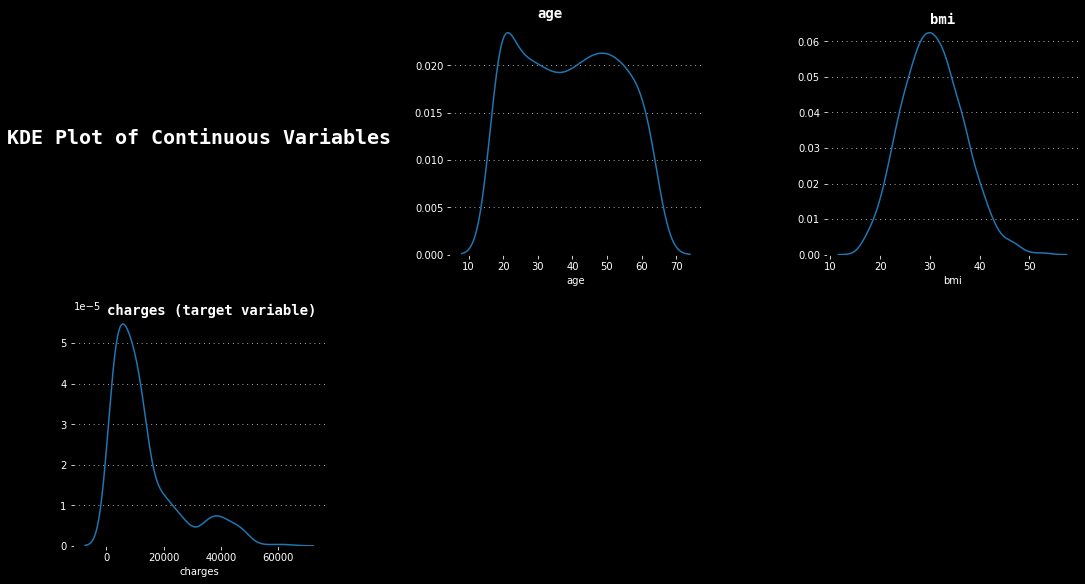

In [10]:
setup("KDE Plot of Continuous Variables",3)

plot(ax1,sns.kdeplot,'age',None,None,30,0.025,'age')
plot(ax2,sns.kdeplot,'bmi',None,None,30,0.065,'bmi')
plot(ax3, sns.kdeplot,'charges',None,None,30,0.000057,'charges (target variable)')

As you can see, charges which the target variable is **right skewed**. There are outliers that cannot be filtered out so we will use **log transformation** when we do modelling. The plot below shows what the observations of the target variable looks like when we apply log transformation.

Here are more articles about when and why to use **log transformation**
https://gdcoder.com/when-why-to-use-log-transformation-in-regression/
https://medium.com/@kyawsawhtoon/log-transformation-purpose-and-interpretation-9444b4b049c9

<AxesSubplot:xlabel='charges', ylabel='Density'>

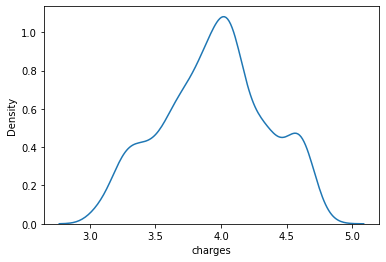

In [11]:
sns.kdeplot(np.log10(insurance['charges']))

**B. Visualizing Categorical Variables Based on the Target Variable**
I won't do univariate analysis of categorical variables, I will just do something about these variables later. Here we are going to plot the ecdf. If you are new to what ecdf is, consider reading this article.
https://towardsdatascience.com/what-why-and-how-to-read-empirical-cdf-123e2b922480

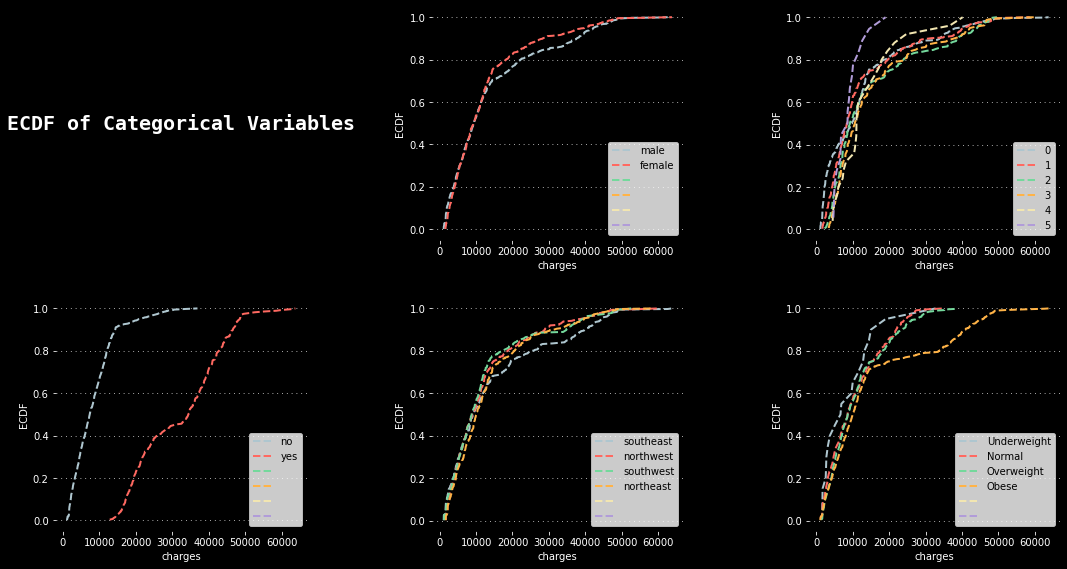

In [12]:
setup("ECDF of Categorical Variables",5)
cdf(ax1,insurance,'sex','male', 'female')
cdf(ax2,insurance,'children',0,1,2,3,4,5)
cdf(ax3,insurance,'smoker', 'no', 'yes')
cdf(ax4,insurance,'region', 'southeast', 'northwest', 'southwest', 'northeast')
cdf(ax5,insurance,'weight_condition', 'Underweight', 'Normal', 'Overweight', 'Obese')

Notice that **smokers and obese** people tend to pay more. Let us focus our analysis on them.

**C. Visualizing Categorical Variables With Respect to Smoking and Weight Condition**

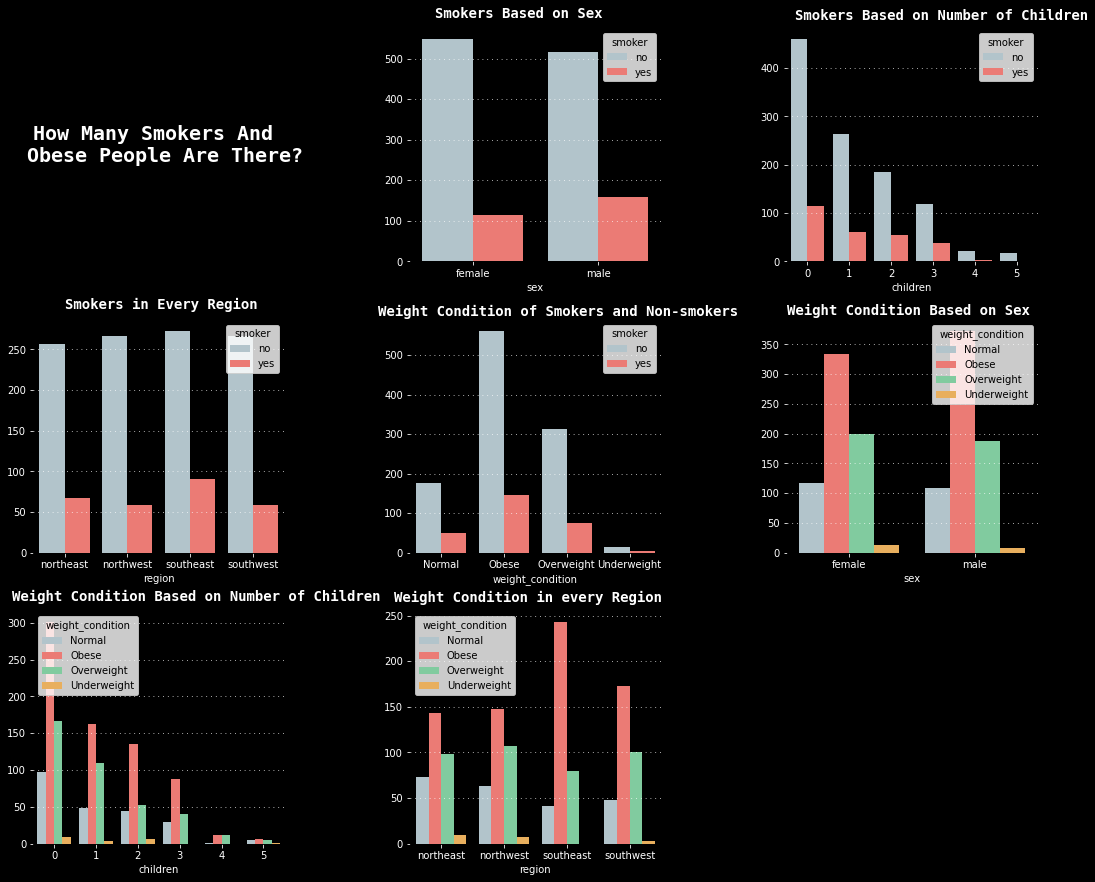

In [13]:
setup("How Many Smokers And \n Obese People Are There?",7)

plot(ax1, sns.countplot,'sex',None,'smoker',-0.3,600,'Smokers Based on Sex')
plot(ax2, sns.countplot, 'children', None, 'smoker',-0.3,500,'Smokers Based on Number of Children')
plot(ax3, sns.countplot, 'region', None, 'smoker',0,300,'Smokers in Every Region')
plot(ax4, sns.countplot, 'weight_condition', None, 'smoker',-1,600,'Weight Condition of Smokers and Non-smokers')
plot(ax5, sns.countplot,'sex',None,'weight_condition',-0.5,400,'Weight Condition Based on Sex')
plot(ax6, sns.countplot, 'children', None, 'weight_condition',-1,330,'Weight Condition Based on Number of Children')
plot(ax7, sns.countplot, 'region', None, 'weight_condition',-0.75,265,'Weight Condition in every Region')


**Insights:**
1. Most of the people in our data are **non-smokers** and **obese**
2. **Males** tend to smoke more than females.
3. People with **no children** smokes more compared to those who have.
4. Most of the people who smoke are **obese people**
5. There are **more obese males** but **in other weight conditions, there are more females** than males. 
6. There are a lot of people who are obese that **do not have children.**
7. People in the **southeast** has the most number of obese people.

**D. Visualizing Continuous Variables With Respect to Smoking and Weight Condition**

I will use the codes inside the function I made instead of using the function itself. Setting my own color palette in a seaborn scatterplot tends to be tricky. If there are only 2 unique observations in a column, then there must only be two colors listed in your palette.

I also got this observation from this notebook again, consider checking it: https://www.kaggle.com/janiobachmann/patient-charges-clustering-and-regression

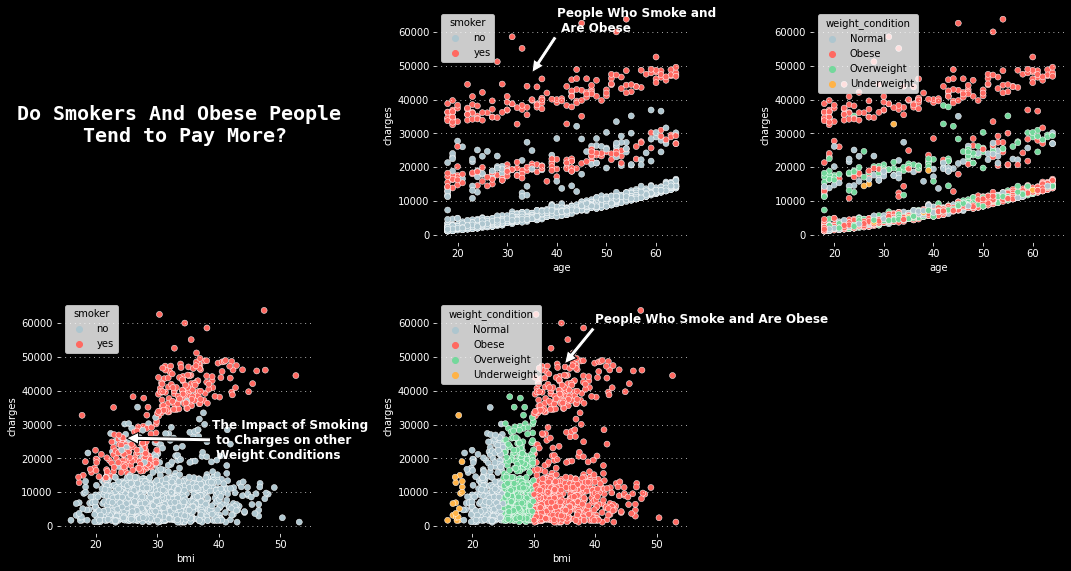

In [14]:
setup("Do Smokers And Obese People \nTend to Pay More?",4)

# Setting up ax1
ax1.grid(color='#ffffff', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.scatterplot(ax=ax1,x = 'age', y = 'charges' , data=insurance, hue = 'smoker',
        palette=["#aec6cf", "#ff6961"])

#Annotations of the plot
# ax1.text(x,y,title, fontsize=14, fontweight='bold', fontfamily='monospace', color="#ffffff")
ax1.set_xlabel('age', color = 'white')
ax1.set_ylabel('charges', color = 'white')
ax1.spines[["top","right","left"]].set_visible(False) # removes the square margins in the graph
ax1.set_facecolor("#000000") #background color of the graph
ax1.annotate('People Who Smoke and\n Are Obese', xy=(35, 48000), xytext=(40, 60000),
            arrowprops=dict(facecolor='white'),
            fontsize=12, color = 'white',fontweight = 'bold')

    
#Changing the color of x ticks and y ticks
ax1.tick_params(axis='x', colors='white')
ax1.tick_params(axis='y', colors='white')

# Setting up ax2
ax2.grid(color='#ffffff', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.scatterplot(ax=ax2,x = 'age', y = 'charges' , data=insurance, hue = 'weight_condition',
        palette=["#aec6cf", "#ff6961", "#74d89c", "#ffb347"])

#Annotations of the plot
# ax2.text(x,y,title, fontsize=14, fontweight='bold', fontfamily='monospace', color="#ffffff")
ax2.set_xlabel('age', color = 'white')
ax2.set_ylabel('charges', color = 'white')
ax2.spines[["top","right","left"]].set_visible(False) # removes the square margins in the graph
ax2.set_facecolor("#000000") #background color of the graph
    
#Changing the color of x ticks and y ticks
ax2.tick_params(axis='x', colors='white')
ax2.tick_params(axis='y', colors='white')

# Setting up ax3
ax3.grid(color='#ffffff', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.scatterplot(ax=ax3,x = 'bmi', y = 'charges' , data=insurance, hue = 'smoker',
        palette=["#aec6cf", "#ff6961"])

#Annotations of the plot
# ax3.text(x,y,title, fontsize=14, fontweight='bold', fontfamily='monospace', color="#ffffff")
ax3.set_xlabel('bmi', color = 'white')
ax3.set_ylabel('charges', color = 'white')
ax3.spines[["top","right","left"]].set_visible(False) # removes the square margins in the graph
ax3.set_facecolor("#000000") #background color of the graph
ax3.annotate('The Impact of Smoking \n to Charges on other \n Weight Conditions ', xy=(25, 26000), xytext=(39, 20000),
            arrowprops=dict(facecolor='white'),
            fontsize=12, color = 'white', fontweight = 'bold')

    
#Changing the color of x ticks and y ticks
ax3.tick_params(axis='x', colors='white')
ax3.tick_params(axis='y', colors='white')

# Setting up ax4
ax4.grid(color='#ffffff', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.scatterplot(ax=ax4,x = 'bmi', y = 'charges' , data=insurance, hue = 'weight_condition',
        palette=["#aec6cf", "#ff6961", "#74d89c", "#ffb347"])

#Annotations of the plot
# ax4.text(x,y,title, fontsize=14, fontweight='bold', fontfamily='monospace', color="#ffffff")
ax4.set_xlabel('bmi', color = 'white')
ax4.set_ylabel('charges', color = 'white')
ax4.spines[["top","right","left"]].set_visible(False) # removes the square margins in the graph
ax4.set_facecolor("#000000") #background color of the graph
ax4.annotate('People Who Smoke and Are Obese', xy=(35, 48000), xytext=(40, 60000),
            arrowprops=dict(facecolor='white'),
            fontsize=12, color = 'white',fontweight = 'bold')

#Changing the color of x ticks and y ticks
ax4.tick_params(axis='x', colors='white')
ax4.tick_params(axis='y', colors='white')





**Insights**
1. **Smokers and obese** people have the highest charges regardless of their age.
2. Even though a person is **not obese but he/she smokes**, his/her charges tends to be higher.
3. **Charges increases as the age of the person increases**

# V. Linear Regression

On this part, I will interpret the **slope and r value** of the plots below using scipy.stats.linregress. Here is the documentation of the function: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.linregress.html

We cannot interpret **intercept** since age and bmi cannot be zero. Note that the intercept is the mean of the target variable (y) when the predictor variable(x) is zero.

I learned more about that in this link:
https://www.statology.org/intercept-in-regression/

And I learned interpreting the slope of the line from DataCamp
https://campus.datacamp.com/courses/exploratory-data-analysis-in-python/relationships?ex=12

**A. Relationship of Age and Charges Based on Smoking**

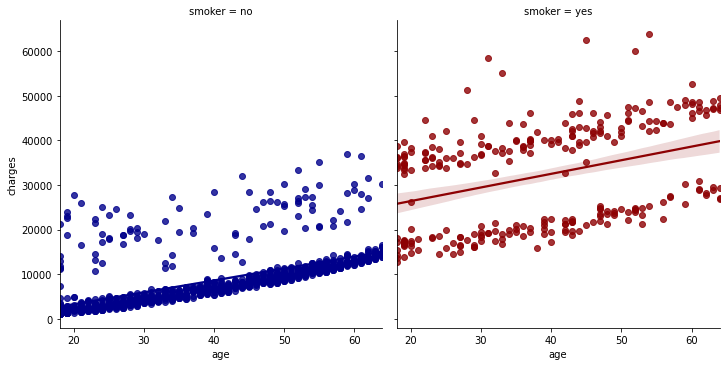

In [15]:
sns.lmplot(x = 'age', y ='charges', hue ='smoker', col = 'smoker', data = insurance,palette=["#00008b", "#8d0103"])

In [16]:
#Separating smokers and non_smokers
smokers = insurance.loc[insurance.smoker == 'yes']
non_smokers = insurance.loc[insurance.smoker == 'no']

#Getting linregress of non smokers
print("Non_Smokers:")
xs0 = non_smokers['age']
ys0 = non_smokers['charges']
res0 = linregress(xs0,ys0)
print(res0)

print("_" *50)

# Getting linregress of smokers
print("Smokers:")
xs1 = smokers['age']
ys1 = smokers['charges']
res1 = linregress(xs1,ys1)
print(res1)


Non_Smokers:
LinregressResult(slope=267.2489128311995, intercept=-2091.420556565079, rvalue=0.6279467837664193, pvalue=9.1720181333733e-118, stderr=10.163738484459296, intercept_stderr=425.102040878521)
__________________________________________________
Smokers:
LinregressResult(slope=305.23760210982897, intercept=20294.128126915963, rvalue=0.36822444373077773, pvalue=3.180585226548615e-10, stderr=46.73056675717474, intercept_stderr=1913.3995320842212)


**Insights:**
1. If you are **not smoking**, every birthday you have increases the possible medical cost by **267.25 dollars.**
2. If you are **smoking**, every birthday you have increases the possible medical cost by **305.24 dollars.**
3. Note that the correlation coefficient of non-smokers are higher than the smokers **BUT** you pay more if you smoke. The statistic we should care about in this plot is the **slope of the line** not the correlation coefficient.

**B. Relationship of BMI and Charges Based on Smoking**

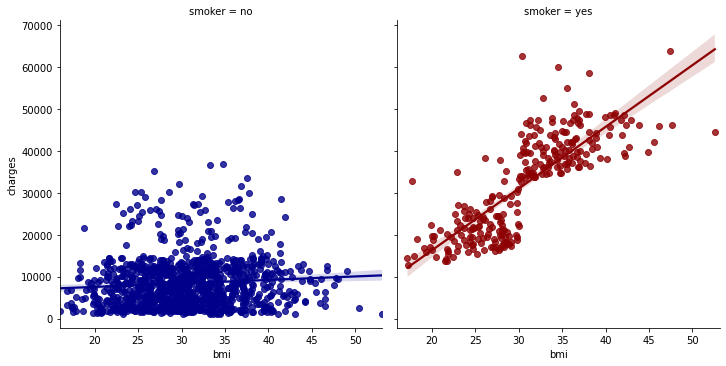

In [17]:
sns.lmplot(x = 'bmi', y ='charges', hue ='smoker', col = 'smoker', data = insurance,palette=["#00008b", "#8d0103"])

In [18]:
#Getting linregress of non_smokers
print("Non_Smokers:")
xs2 = non_smokers['bmi']
ys2 = non_smokers['charges']
res2 = linregress(xs2,ys2)
print(res2)

print("_" *20)

# Getting _____________ of smokers
print("Smokers:")
xs3 = smokers['bmi']
ys3 = smokers['charges']
res3 = linregress(xs3,ys3)
print(res3)


Non_Smokers:
LinregressResult(slope=83.35055766172225, intercept=5879.424081872976, rvalue=0.0840365431283327, pvalue=0.006091408541837674, stderr=30.327674291062852, intercept_stderr=947.4752867682624)
____________________
Smokers:
LinregressResult(slope=1473.1062547014205, intercept=-13186.576322762932, rvalue=0.8064806070155404, pvalue=5.019668631795911e-64, stderr=65.483908237412, intercept_stderr=2052.8848914398463)


**Insights:**
1. It looks like bmi and charges **do not have a linear relationship** for **non-smokers.**
2. If you are **smoking**, every increase of 1 unit of bmi increases the possible medical cost by **1473.11 dollars.**
3. Note that the correlation coefficient of smokers is around **0.8.** This supports our observation earlier that **people who are obese and also smoke** pays high medical cost.

**C. Relationship of Age and Charges Based on Weight Condition**

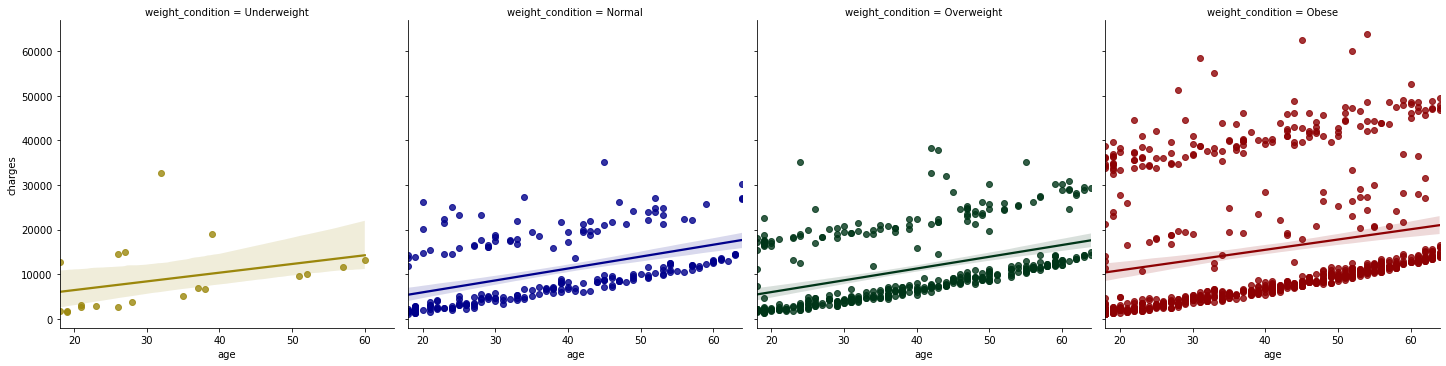

In [19]:
sns.lmplot(x = 'age', y ='charges', hue ='weight_condition', col = 'weight_condition', data = insurance,
          col_order = ['Underweight', 'Normal', 'Overweight', 'Obese'], palette=["#00008b","#8d0103","#003518","#9B870C"])

In [20]:
#Separating smokers and non_smokers
underweight = insurance.loc[insurance.weight_condition == 'Underweight']
normal = insurance.loc[insurance.weight_condition == 'Normal']
overweight = insurance.loc[insurance.weight_condition == 'Overweight']
obese = insurance.loc[insurance.weight_condition == 'Obese']

In [21]:
#Getting linregress of underweight
print("Underweight:")
xs4 = underweight['age']
ys4 = underweight['charges']
res4 = linregress(xs4,ys4)
print(res4)

print("_" *50)

# Getting linregress of normal
print("Normal:")
xs5 = normal['age']
ys5 = normal['charges']
res5 = linregress(xs5,ys5)
print(res5)

print("_" *50)

#Getting linregress of overweight
print("Overweight:")
xs6 = overweight['age']
ys6 = overweight['charges']
res6 = linregress(xs6,ys6)
print(res6)

print("_" *50)

# Getting linregress of obese
print("Obese:")
xs7 = obese['age']
ys7 = obese['charges']
res7 = linregress(xs7,ys7)
print(res7)

Underweight:
LinregressResult(slope=195.22255799481542, intercept=2536.7508338677217, rvalue=0.3402206851861143, pvalue=0.1421731634813458, stderr=127.18050281987371, intercept_stderr=4440.676222684617)
__________________________________________________
Normal:
LinregressResult(slope=266.9160068346308, intercept=604.6230579190051, rvalue=0.4832913653190737, pvalue=1.4309378634607835e-14, stderr=32.37794234515393, intercept_stderr=1267.7957166694991)
__________________________________________________
Overweight:
LinregressResult(slope=263.9067172957878, intercept=715.6588015468496, rvalue=0.4410215622169634, pvalue=8.415369586140384e-20, stderr=27.406765037079168, intercept_stderr=1128.3382451466734)
__________________________________________________
Obese:
LinregressResult(slope=230.1400752295182, intercept=6267.631981214217, rvalue=0.22769485317298965, pvalue=9.114356947946479e-10, stderr=37.066720259127464, intercept_stderr=1587.6569289482504)


**Insights:**
1. The slope of every weight condition tends to be **same**, except for **underweight** but it has a few data points.
2. It is interesting to see that if a person's bmi is **normal**, for every birthday you have, your medical cost increases by **267 dollars.** This is the **highest** compared to other weight conditions.

# VI. Data Preprocessing, Train Test Split, and Scaling

**A. Label Encoding**

In [22]:
#List of categorical variables that we already created earlier
categorical = ["sex","children","smoker","region", "weight_condition"]

#Creating dummy variables on a new dataframe
insurance_ml = pd.get_dummies(data = insurance, columns = categorical, drop_first =True)

#Output
print("The first 5 rows are")
display(insurance_ml.head())

The first 5 rows are


,age,bmi,charges,sex_male,children_1,children_2,children_3,children_4,children_5,smoker_yes,region_northwest,region_southeast,region_southwest,weight_condition_Obese,weight_condition_Overweight,weight_condition_Underweight
0,19,27.900,16884.92400,0,0,0,0,0,0,1,0,0,1,0,1,0
1,18,33.770,1725.55230,1,1,0,0,0,0,0,0,1,0,1,0,0
2,28,33.000,4449.46200,1,0,0,1,0,0,0,0,1,0,1,0,0
3,33,22.705,21984.47061,1,0,0,0,0,0,0,1,0,0,0,0,0
4,32,28.880,3866.85520,1,0,0,0,0,0,0,1,0,0,0,1,0


**B. Log transformation of target variable**

If you are too lazy to scroll up,

Here are more articles about when and why to use **log transformation**
https://gdcoder.com/when-why-to-use-log-transformation-in-regression/
https://medium.com/@kyawsawhtoon/log-transformation-purpose-and-interpretation-9444b4b049c9

In [23]:
#Log Transformation
insurance_ml['charges'] = np.log(insurance_ml['charges'])

#Output
print("The observations of the target variable are:")
display(insurance_ml['charges'])

The observations of the target variable are:


0        9.734176
1        7.453302
2        8.400538
3        9.998092
4        8.260197
          ...    
1333     9.268661
1334     7.698927
1335     7.396233
1336     7.604867
1337    10.279914
Name: charges, Length: 1338, dtype: float64

**C. Train Test Split**

In [24]:
#Getting the features
X = insurance_ml.drop('charges', axis =1)
print("The features of our data are the following:")
display(X.head())

#Getting the target variable
y = insurance_ml['charges']
print("The observations of the target variable are:")
print(y.head())

# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state = 42)
print("_____________________________")
print("The shape of X_train is", X_train.shape)
print("The shape of X_test is", X_test.shape)
print("The shape of y_train is", y_train.shape)
print("The shape of y_test is", y_test.shape)

The features of our data are the following:


,age,bmi,sex_male,children_1,children_2,children_3,children_4,children_5,smoker_yes,region_northwest,region_southeast,region_southwest,weight_condition_Obese,weight_condition_Overweight,weight_condition_Underweight
0,19,27.900,0,0,0,0,0,0,1,0,0,1,0,1,0
1,18,33.770,1,1,0,0,0,0,0,0,1,0,1,0,0
2,28,33.000,1,0,0,1,0,0,0,0,1,0,1,0,0
3,33,22.705,1,0,0,0,0,0,0,1,0,0,0,0,0
4,32,28.880,1,0,0,0,0,0,0,1,0,0,0,1,0


The observations of the target variable are:
0    9.734176
1    7.453302
2    8.400538
3    9.998092
4    8.260197
Name: charges, dtype: float64
_____________________________
The shape of X_train is (1070, 15)
The shape of X_test is (268, 15)
The shape of y_train is (1070,)
The shape of y_test is (268,)


**D. Scaling**

Documentation for StandardScaler:
https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

In [25]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# VII. Modelling

**A. Linear Regression**

In [26]:
#Instatiating model
lr = LinearRegression()
#Fitting
lr.fit(X_train, y_train)    
# Predicting 
y_pred = lr.predict(X_test)    
# Evaluate  accuracy on the test set
print("The R^2 of Linear Regression is:")
print(lr.score(X_test,y_test))

The R^2 of Linear Regression is:
0.8036221287622479


**B. Instantiating Other Models**

In [27]:
# Instatiating other models

dt = DecisionTreeRegressor()

rf = RandomForestRegressor()

ada = AdaBoostRegressor()

gbr = GradientBoostingRegressor()

#Putting models in a list 
regressors = [('Decision Tree Regressor', dt), ('Random Forest Regressor', rf),('AdaBoostRegressor', ada),
              ('Gradient Boosting Regressor', gbr)]

**C. Creating a function for gridsearch, and cross validation at the same time**

My plan is to use **5-fold cross validation** and then tune my hyperparameters using **GridSearchCV**. If you are unfamilar with GridSearchCV and cross validation, check these links:

GridSearch:https://www.mygreatlearning.com/blog/gridsearchcv/

Cross Validation: https://www.upgrad.com/blog/cross-validation-in-python/

My code is similar from this video in DataCamp: https://campus.datacamp.com/courses/machine-learning-with-tree-based-models-in-python/model-tuning?ex=1

In [28]:
def tuning(model_name, parameters):
    #GridSearch and Cross Validation
    grid = GridSearchCV(estimator= model_name,
                       param_grid= parameters,
                       scoring= 'r2',
                       cv= 5,
                       n_jobs=-1)
    
    
    #Fitting
    grid.fit(X_train, y_train)
    
    #Extract best CV score from 'grid_dt'
    best_CV_score = grid.best_score_
    print('Best CV accuracy (untuned):\n',best_CV_score)
    
    #Extract best hyperparameters from grid_dt
    best_hyperparams = grid.best_params_
    print("Best hyperparameters:\n", best_hyperparams)

    # Extract best model from 'grid_dt'
    best_model = grid.best_estimator_
    
    #Evaluate test set accuracy
    test_acc = best_model.score(X_test,y_test)
    print("Test accuracy of the best model (tuned):\n {:.3f}".format(test_acc))

**D. Getting the parameters of models**

In [29]:
#Getting the parameters of models
for regressor_name, model in regressors:
    print("The parameters of {:s} are the following:".format(regressor_name))
    print(model.get_params())
    print("-" *50)

The parameters of Decision Tree Regressor are the following:
{'ccp_alpha': 0.0, 'criterion': 'mse', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'presort': 'deprecated', 'random_state': None, 'splitter': 'best'}
--------------------------------------------------
The parameters of Random Forest Regressor are the following:
{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'mse', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
--------------------------------------------------
The parameters of AdaBoostRegressor are the following:
{'base_estimat

**E. Setting parameters to be tuned**

In [30]:
#Decision Tree Regressor
params_dt = {'max_depth':[5,6,7],'min_samples_leaf':[0.02,0.04,0.06]}

#Random Forests Regressor
params_rf = {'max_depth':[5,6,7],'n_estimators':[400,500,600]}

# AdaBoostRegressor
params_ada = {'n_estimators':[50,100,150], 'learning_rate':[0.001,0.0025,0.005]}

#GradientBoostingRegressor
params_gbr =  {'n_estimators':[100,200,300,400],'learning_rate':[0.01,0.025,0.05], 
               'min_samples_split':[0.01,0.025,0.05]}


**F. Scoring**

R^2 is used in scoring the model. If you are unfamiliar with this, check this link:
https://towardsdatascience.com/data-science-explaining-r%C2%B2-in-statistics-6f34e7f0a9bb

In [31]:
print("Decision Tree Regressor:")
tuning(dt,params_dt)
print("-" *50)

print("Random Forests Regressor:")
tuning(rf, params_rf)
print("-" *50)

print('AdaBoost Regressor:')
tuning(ada, params_ada)
print("-" *50)

print('GradientBoosting Regressor:')
tuning(gbr, params_gbr)
print("-" *50)

Decision Tree Regressor:
Best CV accuracy (untuned):
 0.7962259291939825
Best hyperparameters:
 {'max_depth': 5, 'min_samples_leaf': 0.04}
Test accuracy of the best model (tuned):
 0.832
--------------------------------------------------
Random Forests Regressor:
Best CV accuracy (untuned):
 0.8052721632873894
Best hyperparameters:
 {'max_depth': 5, 'n_estimators': 400}
Test accuracy of the best model (tuned):
 0.849
--------------------------------------------------
AdaBoost Regressor:
Best CV accuracy (untuned):
 0.7918024858194128
Best hyperparameters:
 {'learning_rate': 0.0025, 'n_estimators': 150}
Test accuracy of the best model (tuned):
 0.820
--------------------------------------------------
GradientBoosting Regressor:
Best CV accuracy (untuned):
 0.8145342456722797
Best hyperparameters:
 {'learning_rate': 0.025, 'min_samples_split': 0.025, 'n_estimators': 300}
Test accuracy of the best model (tuned):
 0.852
--------------------------------------------------


**Gradient Boosting Has the Highest R^2!**

**IF YOU MADE THIS FAR, PLEASE CONSIDER GIVING AN UPVOTE!**

**ALSO, COMMENTS, SUGGESTIONS, AND RECOMMENDATIONS ARE HIGHLY APPRECIATED!**

Here are my other notebooks, consider checking them out!

1. **Auto EDA and Instant Cluster Analysis using Python** -> https://www.kaggle.com/sinoro12/auto-eda-and-instant-cluster-analysis

1. **Exploratory Data Analysis using R** -> https://www.kaggle.com/sinoro12/are-filipinos-having-fun-in-the-philippines/edit/run/74090855

1. **First Notebook in Kaggle where I used GGPLOT in R** (visit this if you have no idea how to interpret boxplots!) ->  https://www.kaggle.com/sinoro12/understanding-your-ggplot2-visualizations

1. **Classification using Python** -> https://www.kaggle.com/sinoro12/who-is-prone-to-heart-disease-95-accuracy/notebook